In [1]:
import librosa
import os
import warnings
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# Make sure you find references for use of features & justification of hyperparameters for music

def load_and_split(audios, sr, segments=3):
    """
    Loads in the mp3 files available for the model and splits each into x segments. Default is 3 so each segment will be 5 seconds long (15 second total each)

    Args:
        audios -> Dictionary of audio ids and full audio path
                    e.g. {0:'...7horsemethlabzosostickerthewolfofwallstreetsample1mp3.mp3'}
        sr -> Desired sample rate for loading in the audio files with
                Audio files are natively 44.1k but not set as default to enable use in other functions

    Outputs:
        1. Audio IDs -> Numpy array, duplicates as ID will be copied in for each segment (use for finding the corresponding film metadata)
        2. Librosa loaded audio samples -> 2D Numpy array, each row corresponds to a unique audio segment
    """

    ids, data = [], []

    for id, path in tqdm(audios.items(), desc="Processing audio files"):
        signal, _ = librosa.load(path, sr=sr)
        segment_length = len(signal) / segments

        # Librosa loaded file is just a numpy array so possible to segment using slicing
        for i in range(segments):
            start = int(i * segment_length)
            end = int(start + segment_length)
            samples = signal[start:end]
            ids.append(id), data.append(samples)

    return np.array(ids), np.array(data)

def feature_extraction(data, sr, hop_length=1024, n_fft=4096):
    """
    Extracts audio features from the librosa time series and standardises

    Args:
        data -> Numpy array of Librosa loaded audio segments
        sr -> Sample rate
        hop_length & n_fft -> Hyperparameters to be shared across various features

    Output:
        X -> Numpy matrix of audio features of shape (# samples, # features)
    """

    X = []

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for i in tqdm(range(len(data)), desc="Extracting audio features"):
            y = data[i]
            
            # --- Timbral Features ---
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, n_mels=60, n_fft=n_fft, hop_length=hop_length, fmin=20, fmax=22050, lifter=30, win_length=n_fft, window='hann')
            f_mfccmean = np.mean(mfccs, axis=1)
            f_mfccstd = np.std(mfccs, axis=1)
            f_speccentoid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length, n_fft=n_fft))
            f_specband = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr, hop_length=hop_length, n_fft=n_fft))
            f_speccontrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=hop_length, n_fft=n_fft))

            # --- Rhythm Features ---
            f_tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr, hop_length=hop_length)
            beat_times = librosa.frames_to_time(beat_frames, sr=sr, hop_length=hop_length, n_fft=n_fft)
            beat_indices = librosa.time_to_frames(beat_times, sr=sr, hop_length=hop_length, n_fft=n_fft)
            f_beatrms = np.nan_to_num(np.mean(librosa.feature.rms(y=y, hop_length=hop_length)[0, beat_indices])) # Error handling -> Convert to 0 as tempo will also be 0
            f_onsetstrength = np.mean(librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length, n_fft=n_fft))
            
            # --- Loudness Features ---
            rms = librosa.feature.rms(y=y, hop_length=hop_length)
            f_rmsmean = np.mean(rms)
            f_rmsstd = np.std(rms)

            # --- Harmonic Features ---
            chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length, n_fft=n_fft)
            f_chromamean = np.mean(chroma, axis=1)
            f_chromastd = np.std(chroma, axis=1) 

            features = np.hstack((f_mfccmean, f_mfccstd, f_speccentoid, f_specband, f_speccontrast, f_tempo, f_beatrms, f_onsetstrength, f_rmsmean, f_rmsstd, f_chromamean, f_chromastd))
            X.append(features)

    return np.array(X)

def feature_selection_standardised(X, kpca, standardise=True, var_threshold=0.15, corr_threshold=0.75, n_components=8):
    """
    Performs variance and correlation feature selection and kernel PCA on the feature matrix
    Drops columns with a variance less than var_threshold and drops one of two correlated features greater than corr_threshold
    Also standardises the data, very important for PCA

    Args:
        X -> Feature matrix (# samples, # features)
        kpca -> Boolean, performs PCA if true
        standardise -> Boolean, standardises feature matrix if true
        var_threshold -> Lower limit of acceptable variance, features with lower variance will be dropped
        corr_threshold -> Upper limit of acceptable correlation, only drops one of the two correlated features if correlation is greater than the threshold
        n_components -> Number of components for PCA

    Output:
        X_reduced -> Matrix with reduced features
    """

    X_reduced = VarianceThreshold(threshold=var_threshold).fit_transform(X)

    df = pd.DataFrame(X_reduced)
    corrs = df.corr().abs()         # Only absolute size of correlation matters, not direction

    # 1. Returns boolean matrix of same shape as correlation matrix. True for the values above the self correlation diagonal
    # 2. Transforms the correlation matrix -> All NaN below and including the diagonal, keeps values above the diagonal
    upper = corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(bool))
    X_reduced = df.drop(columns=[col for col in upper.columns if any(upper[col] > corr_threshold)])     # Finds columns in correlation matrix with any correlation higher than the threshold
    
    if standardise: X_reduced = StandardScaler().fit_transform(X_reduced)

    if kpca:
        kpca = KernelPCA(n_components=n_components)
        X_reduced = kpca.fit_transform(X_reduced)
        for i, l in enumerate(kpca.eigenvalues_): print(f'Component {i} roughly explains {l / sum(kpca.eigenvalues_):.3%} variance')

    return X_reduced

def evaluate_plot(X, model, k=30):
    """
    Evaluates multiple unsupervised metrics against the number of clusters
    
    Args:
        X -> Standardised feature matrix
        model -> Model to use, either GMM or kMeans
        k -> Max clusters to test
    
    Outputs:
        Plots of metric v cluster
    """

    clusters, CH, SS, DB = [], [], [], []

    if model == 'kmeans':
        for k in range(2, k):
            kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
            labels = kmeans.labels_
            clusters.append(k), CH.append(calinski_harabasz_score(X, labels)), SS.append(silhouette_score(X, labels)), DB.append(davies_bouldin_score(X, labels))

    elif model == 'gmm':
        for k in range(2, k):
            gmm = GaussianMixture(n_components=k, random_state=42).fit(X)
            labels = gmm.predict(X)
            clusters.append(k), CH.append(calinski_harabasz_score(X, labels)), SS.append(silhouette_score(X, labels)), DB.append(davies_bouldin_score(X, labels))

    metrics = [
        (CH, 'Calinski-Harabasz Score', 'Calinski-Harabasz v Number of Clusters'),
        (SS, 'Silhouette Score', 'Silhouette Score v Number of Clusters'),
        (DB, 'Davies-Bouldin Score', 'Davies-Bouldin v Number of Clusters')]

    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    for i, (metric, label, title) in enumerate(metrics):
        ax[i].plot(clusters, metric)
        ax[i].set_ylabel(label, fontweight='bold')
        ax[i].set_xlabel('Clusters', fontweight='bold')
        ax[i].set_title(title, fontsize=14)
    plt.show()
    
    return None

def cluster_viz(X, model, clusters):
    """
    Visualises cluster assignment for a feature matrix of just 2 features
    Use PCA to reduce feature matrix to 2 components

    Args:
        X -> Standardised feature matrix of 2 features
        model -> Clustering model to use, k-means or gmm
        clusters -> Number of clusters to use in model

    Output:
        Plot of colour-coded clusters
    """

    if model == 'kmeans':
        labels = KMeans(n_clusters=clusters, random_state=42).fit_predict(X)
    elif model == 'gmm':
        labels = GaussianMixture(n_components=clusters, random_state=42).fit_predict(X)

    fig, ax = plt.subplots(1, 1, figsize=(9, 6))
    scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
    ax.set_title(f'{model}\nk = {clusters}', fontweight='bold', fontsize=17)
    ax.legend(*scatter.legend_elements(), title='Clusters')
    plt.show()
    
    return None

def cluster_predict(X, clusters, sample_audio_ids, audio_dict, AV_scores):
    """
    Clusters the feature matrix using k-Means and aggregates samples from the same audio file together for each label.
    For example, assume 2 samples from audio ID 54 are labelled as cluster 3. The median of these two samples will be calculated and stored with the process repeated for each cluster

    Aggregates (median) arousal-valence scores for each unique audio file, given that participants scored the same audio file multiple times and multiple participants scored the same audio file
    Aggregates familiarity ratings according to the highest count

    Args:
        X -> Standardised feature matrix
        clusters -> Number of clusters to use in k-means
        sample_audio_ids -> List of audio IDs for each sample in the feature matrix
        audio_dict -> Dictionary of audio IDs to filepaths --- {0:'...7horsemethlabzosostickerthewolfofwallstreetsample1mp3.mp3'}
        AV_scores -> Dataframe of arousal-valence scores and film metadata

    Outputs:
        1. cluster_df -> Dataframe of filepaths, clusters, aggregate arousal + valence, and film metadata
        2. median_cluster_scores -> Dataframe of median arousal + valence for each cluster

    """

    # ----- Clustering + Retrieving distance to assigned cluster -----
    kmeans = KMeans(n_clusters=clusters, random_state=42).fit(X)
    dist, label = kmeans.transform(X), kmeans.predict(X)
    dist_assigned = dist[np.arange(X.shape[0]), label]

    # ----- Aggregate Distance for Samples from same Audio in same Cluster -----
    dist_df = pd.DataFrame({'file':sample_audio_ids, 'label':label, 'dist_centroid':dist_assigned})     \
                .groupby(['file','label'])['dist_centroid'].median().reset_index()                      \
                .sort_values(by=['label','dist_centroid']).reset_index(drop=True)
    dist_df['file'] = [os.path.basename(audio_dict[id]) for id in dist_df['file']]

    # ----- Aggregate Valence, Arousal, Familiarity + Join with AV_scores for Film Metadata -----
    agg_AV = AV_scores.groupby('file').agg({'valence':'median','arousal':'median','familiarity':lambda x: x.value_counts().index[0]})
    agg_AV = pd.merge(agg_AV, AV_scores.drop(columns=['familiarity','arousal','valence']).drop_duplicates(subset=['file']).set_index('file'), on='file').reset_index()

    # ----- Merge Distance with Aggregate AV + AV Aggregation for Clusters -----
    cluster_df = pd.merge(dist_df, agg_AV, how='left', on='file')
    median_cluster_scores = cluster_df.groupby('label').agg({'valence':'median', 'arousal':'median'}).reset_index()

    return cluster_df, median_cluster_scores

def find_recommendations(cluster_df, cluster_scores, top_k=5):
    """
    Requests an input from the user for an arousal-valence score
    Calculates Euclidean distances between input and AV scores of each of the centroids - Returns cluster label
    Uses cluster label to filter clustered samples for only the relevant cluster, sorts by distance to centroid and returns the top_k audio tracks with the shortest distances

    Args:
        cluster_df -> Dataframe of clustered audio tracks including their AV scores, distance to assigned centroid and label
        cluster_scores -> Median AV scores of all the audio tracks assigned to each cluster
        top_k -> k results to retrieve

    Output:
        retrieved_tracks -> Dataframe of audio tracks assigned to the closest centroid to the input Arousal-Valence score. Length of dataframe = top_k
    """

    # ----- Arousal Input -----
    while True:
        try:
            arousal = float(input('Please input an arousal score between -1 and +1'))
            if abs(arousal) > 1:
                print('Please enter a number between -1 and +1')
                continue
            break
        except:
            print('Please enter a valid number')
            continue

    # ----- Valence Input -----
    while True:
        try:
            valence = float(input('Please input an valence score between -1 and +1'))
            if abs(valence) > 1:
                print('Please enter a number between -1 and +1')
                continue
            break
        except:
            print('Please enter a valid number')
            continue

    
    input_score = np.array([arousal, valence])
    centroids = cluster_scores[['arousal','valence']].to_numpy()
    dist = np.linalg.norm(centroids - input_score, axis=1)              # Euclidean distance between input AV score and AV scores of each of the centroids
    closest_centroid = cluster_scores.iloc[np.argmin(dist)]['label']    # Finds index of minimum distance and uses this to filter cluster_scores
    
    retrieved_tracks = cluster_df.loc[cluster_df['label'] == closest_centroid].sort_values(by='dist_centroid', ignore_index=True).head(top_k)
    print(f'Arousal-Valence: ({str(input_score[0])}, {str(input_score[1])})')

    return retrieved_tracks

In [3]:
AV_scores = pd.read_csv(os.path.join(os.getcwd(), 'CSV_files', 'arousal_valence.csv'))
audio_dict = {index:os.path.join(os.getcwd(), 'audios', file) for index, file in enumerate(sorted(AV_scores['file'].unique()))}

ids, data  = load_and_split(audio_dict, sr=44100)
X = feature_extraction(data, sr=44100)

Extracting audio features: 100%|██████████| 1227/1227 [01:42<00:00, 11.94it/s]


Component 0 roughly explains 61.907% variance
Component 1 roughly explains 38.093% variance


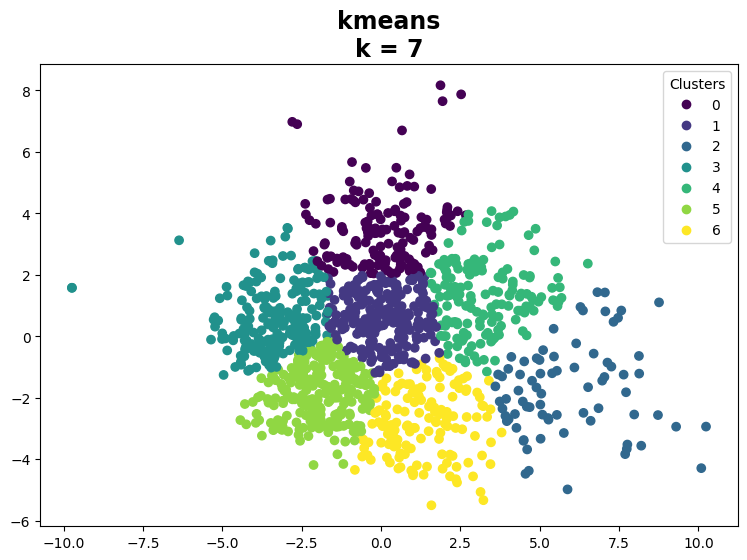

In [4]:
X_processed = feature_selection_standardised(X, kpca=True, n_components=2)
cluster_viz(X_processed, model='kmeans', clusters=7)

Component 0 roughly explains 35.407% variance
Component 1 roughly explains 21.787% variance
Component 2 roughly explains 14.906% variance
Component 3 roughly explains 10.855% variance
Component 4 roughly explains 9.025% variance
Component 5 roughly explains 8.020% variance


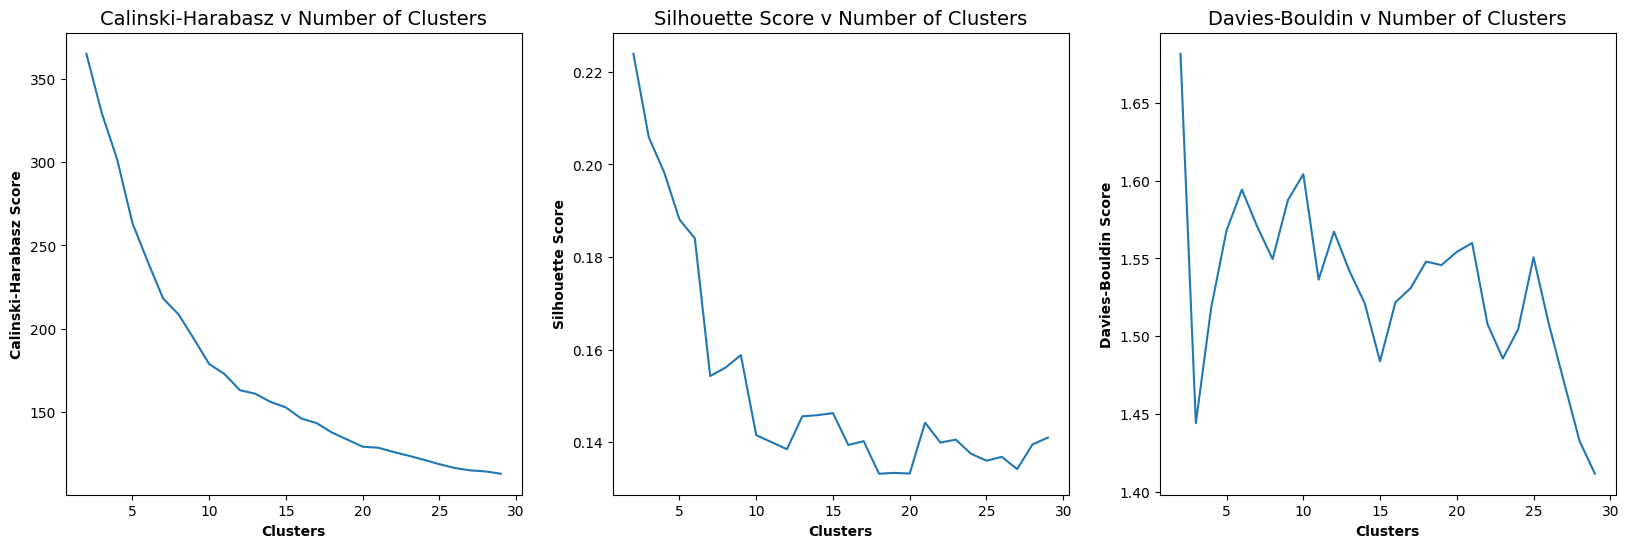

In [5]:
X_processed = feature_selection_standardised(X, kpca=True, n_components=6)
evaluate_plot(X_processed, 'kmeans')

In [6]:
X_processed = feature_selection_standardised(X, kpca=True, n_components=6)
cluster_df, cluster_scores = cluster_predict(X_processed, 7, ids, audio_dict, AV_scores)

cluster_df.to_csv(os.path.join(os.getcwd(), 'CSV_files', 'tracks_clustered.csv'), index=False)
cluster_scores.to_csv(os.path.join(os.getcwd(), 'CSV_files', 'cluster_scores.csv'), index=False)

Component 0 roughly explains 35.407% variance
Component 1 roughly explains 21.787% variance
Component 2 roughly explains 14.906% variance
Component 3 roughly explains 10.855% variance
Component 4 roughly explains 9.025% variance
Component 5 roughly explains 8.020% variance


In [7]:
find_recommendations(cluster_df, cluster_scores)


Arousal-Valence: (-0.33, 0.76)


,file,label,dist_centroid,valence,arousal,familiarity,title,composer,film,year,genre,director
0,acrosstheoceanthomasnewmanelementalsample2mp3.mp3,0,1.168654,0.34148,0.58555,familiar-feeling-not-familiar,Across The Ocean,Thomas Newman,Elemental,2023.0,Animation Adventure Comedy,Peter Sohn
1,wontgetfooledagainthewhotopgunmavericksample2mp3.mp3,0,1.251066,0.81568,0.71750,definitely-familiar,Won't Get Fooled Again,Pete Townsend / The Who,Top Gun: Maverick,2022.0,Action Drama,Joseph Kosinski
2,summermontagemadelinelalalandjustinhurwitzsample1mp3.mp3,0,1.378536,0.95531,0.94583,definitely-familiar,Summer Montage / Madeline,Justin Hurwitz,La La Land,2016.0,Comedy Drama Music,Damien Chazelle
3,whiplashhanklevysample2mp3.mp3,0,1.458435,0.33445,0.35555,not-sure,Whiplash,Hank Levy,Whiplash,2014.0,Drama Music,Damien Chazelle
4,upisdownhanszimmerpiratesofthecaribbeanatworldsendsample2mp3.mp3,0,1.482938,0.36250,0.02602,never-heard-this,Up Is Down,Hans Zimmer,Pirates of the Caribbean: At World's End,2007.0,Action Adventure Fantasy,Gore Verbinski
